#### For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
llm.invoke("hi")


AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001988536, 'queue_time': 0.233836558, 'total_time': 0.029261263}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-530a69ab-a3cc-4ee5-a097-d00b9032b054-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

In [4]:
llm.invoke("hi").content

'Hi there! 👋  What can I do for you today?\n'

In [5]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [6]:
multiply({"first_number":24,"second_number":364})

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_10752\2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [7]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [8]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [9]:
search("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Presidents, vice presidents, and first ladies | USAGov An official website of the United States government A .gov website belongs to an official government organization in the United States. Learn about the duties of president, vice president, and first lady of the United States. President of the United States The president of the United States is the: Former U.S. presidents The United States has had 46 former U.S. presidents. Vice president of the United States The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. The 50th and current vice president of the United States is James David (JD) Vance.',
  'score': 0.65412235},
 {'title': 'The Trump Administration - The White House',
  'url': 'https://www.whitehouse.gov/administration/',
  'co

In [10]:
tools=[search,multiply]
model_with_tools=llm.bind_tools(tools)

In [23]:
for tool in tools:
    print(tool)

name='search' description='perform the web search on the user query' args_schema=<class 'langchain_core.utils.pydantic.search'> func=<function search at 0x0000021E961FC4C0>
name='multiply' description='multiply two integer number' args_schema=<class 'langchain_core.utils.pydantic.multiply'> func=<function multiply at 0x0000021E92673D90>


In [24]:
tool.name

'multiply'

In [11]:
tool_mapping={tool.name: tool for tool in tools}

In [12]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000021E961FC4C0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000021E92673D90>)}

In [13]:
response=model_with_tools.invoke("who is a current president of USA?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0r5e', 'function': {'arguments': '{"query":"who is the current president of the USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.037745622, 'queue_time': 0.23661834899999998, 'total_time': 0.194109258}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a994adae-a6e1-4c88-aa25-a84915bb749c-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of the USA'}, 'id': 'call_0r5e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})

In [14]:
tool_details=response.additional_kwargs.get("tool_calls")

In [15]:
tool_details

[{'id': 'call_0r5e',
  'function': {'arguments': '{"query":"who is the current president of the USA"}',
   'name': 'search'},
  'type': 'function'}]

In [16]:
tool_details[0]["function"]["name"]

'search'

In [17]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of the USA"}'

In [18]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'The White House',
  'url': 'https://www.whitehouse.gov/',
  'content': 'The White House President Donald J. Trump The White House Administration America Is Back I will not rest until we have delivered the strong, safe and prosperous America that our children deserve and that you deserve. This will truly be the golden age of America. Donald J. Trump President of the United States VICE PRESIDENT OF THE UNITED STATES Melania Trump First Lady OF THE UNITED STATES President Trump is committed to lowering costs for all Americans, securing our borders, unleashing American energy dominance, restoring peace through strength, and making all Americans safe and secure once again. Get direct updates from The White House in your inbox. The White house THE WHITE HOUSE The White House 1600 Pennsylvania Ave NW',
  'score': 0.69697046},
 {'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Presidents, vice presidents, an

In [19]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [20]:
def invoke_model(state:AgentState):
    messages=state['messages']
    question=messages[-1] ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [25]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [26]:
def router(state):
    tool_calls=state["messages"][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        "end"

In [29]:
graph=StateGraph(AgentState)
graph.add_node("ai_assistant",invoke_model)
graph.add_node('tool',invoke_tool)
graph.add_conditional_edges("ai_assistant",router,{"tool":"tool","end":END})
graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app = graph.compile()

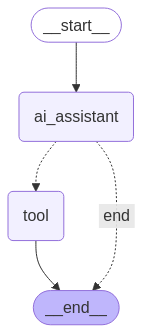

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2d4z', 'function': {'arguments': '{"query":"who is the upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1075, 'total_tokens': 1161, 'completion_time': 0.156363636, 'prompt_time': 0.037906074, 'queue_time': 0.23355510899999998, 'total_time': 0.19426971}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6aff716e-e33a-48e3-aefb-ad0cdf3314d4-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the upcoming president of USA'}, 'id': 'call_2d4z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 86, 'total_tokens': 1161})]}
----
Selected tool: search
{'messages': [[{'title': '2024 United States presidential election - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/2024_United_States_presidential_e

In [32]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0qj5', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1080, 'total_tokens': 1172, 'completion_time': 0.167272727, 'prompt_time': 0.037669564, 'queue_time': 0.23591154800000003, 'total_time': 0.204942291}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8ec50c46-258a-4126-b9b6-f5344704eaa8-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_0qj5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 92, 'total_tokens': 1172})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [33]:
for s in app.stream({"messages": ["what is the total amount of money exist over the earth?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5bhr', 'function': {'arguments': '{"query":"total amount of money exist over the earth"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1080, 'total_tokens': 1167, 'completion_time': 0.158181818, 'prompt_time': 0.046525628, 'queue_time': 0.23671022400000002, 'total_time': 0.204707446}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d1b041ed-e975-40d1-8fe3-4824e5dd2a01-0', tool_calls=[{'name': 'search', 'args': {'query': 'total amount of money exist over the earth'}, 'id': 'call_5bhr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 87, 'total_tokens': 1167})]}
----
Selected tool: search


Exception: web search discard

#### LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.